In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import copy
import math
from dataclasses import dataclass
from pathlib import Path
from functools import partial
from typing import Callable, Optional, Tuple, Union

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import scipy.stats
import seaborn as sns
from tqdm.notebook import tqdm

import score_analysis
from score_analysis import BinaryLabel, Scores
from score_analysis.experimental.roc_ci import (
    NormalDataset, 
    roc, 
    roc_with_ci,
)

In [4]:
sns.set_style("darkgrid")
sns.set_context("notebook")

In [5]:
def apply_label_noise(scores: Scores, p: float, shuffle: bool) -> Scores:
    if shuffle:
        scores = copy.deepcopy(scores)
        scores.pos = np.random.permutation(scores.pos)
        scores.neg = np.random.permutation(scores.neg)
    
    # After mixing, we want the level of label noise to be the same in both pos and neg.
    # That means that the length of neg determines how many samples from pos need to
    # be added to neg.
    pos_idx = math.floor(len(scores.neg) * p)
    neg_idx = math.floor(len(scores.pos) * p)
    # neg_idx = 0

    return Scores(
        pos = np.concatenate([scores.pos[pos_idx:], scores.neg[:neg_idx]]),
        neg = np.concatenate([scores.neg[neg_idx:], scores.pos[:pos_idx]]),
    )

In [6]:
dataset = NormalDataset.from_metrics(
    fnr=0.02,
    fpr=0.10,
    fnr_support=100,
    fpr_support=100,
)
clean_scores = dataset.sample()

# After permutation we cannot use clean_scores any more for metric computation,
# but we have a consistent way to apply label noise by selecting the first N
# samples from each class.
clean_scores.pos = np.random.permutation(clean_scores.pos)
clean_scores.neg = np.random.permutation(clean_scores.neg)

In [7]:
# We assume that we have a second classifier. First, we assume that the classifiers
# have the same ordering of what is easy/difficult, i.e., the scores of the second
# classifier are in the same order as for the first classifier, but shifted.
clean_scores_2 = copy.deepcopy(clean_scores)

clean_scores_2.neg = clean_scores_2.neg - 0.15
# Instead of shifting the distribution, we can also make the distribution narrower
# mu = clean_scores_2.neg.mean()
# clean_scores_2.neg = (clean_scores_2.neg - mu) * 0.9 + mu

# Then we create sorted objects to plot ROC curves
scores = Scores(pos=clean_scores.pos, neg=clean_scores.neg)
scores_2 = Scores(pos=clean_scores_2.pos, neg=clean_scores_2.neg)

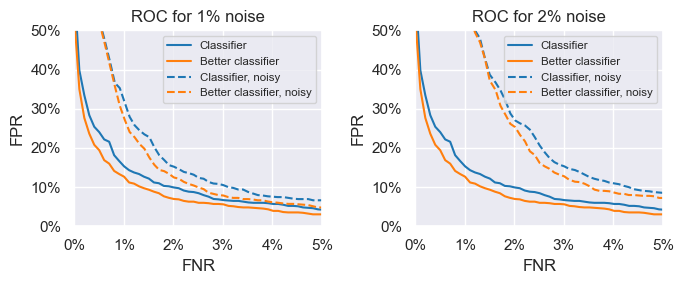

In [11]:
x = np.linspace(0., 1., 1_000, endpoint=True)

plt.figure(figsize=(7, 3))
for j, p_noise in enumerate([0.01, 0.02], start=1):
    plt.subplot(1, 2, j)
    
    # First, we plot clean scores
    fnr, fpr = roc(scores, fnr=x)
    fnr_2, fpr_2 = roc(scores_2, fnr=x)
    plt.plot(fnr, fpr, label="Classifier")
    plt.plot(fnr_2, fpr_2, label="Better classifier")
    
    # And then we plot noisy scores
    scores_noisy = apply_label_noise(clean_scores, p=p_noise, shuffle=False)
    scores_noisy_2 = apply_label_noise(clean_scores_2, p=p_noise, shuffle=False)
    fnr, fpr = roc(scores_noisy, fnr=x)
    fnr_2, fpr_2 = roc(scores_noisy_2, fnr=x)

    plt.gca().set_prop_cycle(None)  # To reset color cycling
    plt.plot(fnr, fpr, "--", label="Classifier, noisy")
    plt.plot(fnr_2, fpr_2, "--", label="Better classifier, noisy")

    plt.xlim([0, 0.05])
    plt.ylim([0, 0.5])
    plt.xlabel("FNR")
    plt.ylabel("FPR")
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1., decimals=0))
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1., decimals=0))
    plt.title(f"ROC for {p_noise:.0%} noise")
    plt.legend(fontsize="x-small")

plt.tight_layout()
plt.show()

In [18]:
# The other extreme are classifiers whose scores are uncorrelated. We simulate this
# by sampling a new dataset for the second classifier (with the same distribution, which
# we then adjust.
clean_scores_2 = dataset.sample()

clean_scores_2.neg = clean_scores_2.neg - 0.15
# Instead of shifting the distribution, we can also make the distribution narrower
# mu = clean_scores_2.neg.mean()
# clean_scores_2.neg = (clean_scores_2.neg - mu) * 0.9 + mu

# Then we create sorted objects to plot ROC curves
scores = Scores(pos=clean_scores.pos, neg=clean_scores.neg)
scores_2 = Scores(pos=clean_scores_2.pos, neg=clean_scores_2.neg)

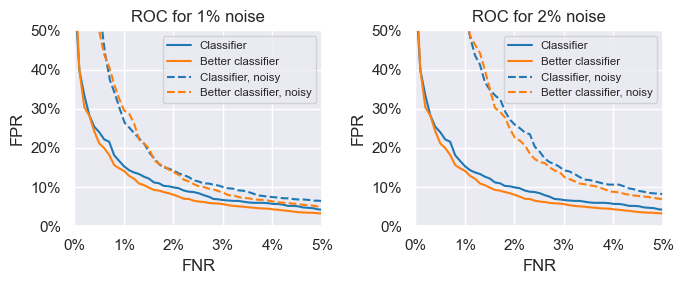

In [19]:
x = np.linspace(0., 1., 1_000, endpoint=True)

plt.figure(figsize=(7, 3))
for j, p_noise in enumerate([0.01, 0.02], start=1):
    plt.subplot(1, 2, j)
    
    # First, we plot clean scores
    fnr, fpr = roc(scores, fnr=x)
    fnr_2, fpr_2 = roc(scores_2, fnr=x)
    plt.plot(fnr, fpr, label="Classifier")
    plt.plot(fnr_2, fpr_2, label="Better classifier")
    
    # And then we plot noisy scores
    scores_noisy = apply_label_noise(clean_scores, p=p_noise, shuffle=True)
    scores_noisy_2 = apply_label_noise(clean_scores_2, p=p_noise, shuffle=True)
    fnr, fpr = roc(scores_noisy, fnr=x)
    fnr_2, fpr_2 = roc(scores_noisy_2, fnr=x)

    plt.gca().set_prop_cycle(None)  # To reset color cycling
    plt.plot(fnr, fpr, "--", label="Classifier, noisy")
    plt.plot(fnr_2, fpr_2, "--", label="Better classifier, noisy")

    plt.xlim([0, 0.05])
    plt.ylim([0, 0.5])
    plt.xlabel("FNR")
    plt.ylabel("FPR")
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1., decimals=0))
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1., decimals=0))
    plt.title(f"ROC for {p_noise:.0%} noise")
    plt.legend(fontsize="x-small")

plt.tight_layout()
plt.show()

As a results, things get noisier. In the noisy FRR range (FRR < p_noise), the ordering of the classifiers is not consistent any more.

## Genuine composition in dataset with label noise

In [13]:
dataset = NormalDataset.from_metrics(
    fnr=0.02,
    fpr=0.10,
    fnr_support=100,
    fpr_support=500,
)
scores = dataset.sample(n=100_000)

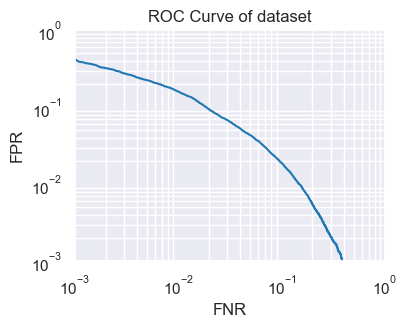

In [15]:
x = np.linspace(0., 1., 10_000, endpoint=True)
fnr, fpr = roc(scores, fnr=x)

plt.figure(figsize=(4, 3))
plt.plot(fnr, fpr)
plt.xlim([1e-3, 1e0])
plt.ylim([1e-3, 1e0])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("FNR")
plt.ylabel("FPR")
plt.grid(which="both")
plt.title("ROC Curve of dataset")
plt.show()

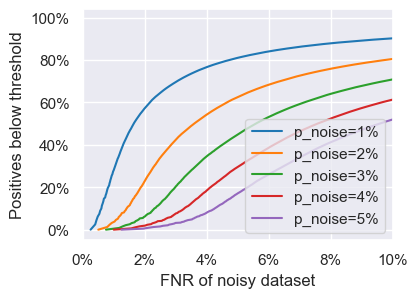

In [17]:
x = np.linspace(0., 1., 10_000, endpoint=True)
threshold = scores.threshold_at_fnr(x)

plt.figure(figsize=(4, 3))
for p_noise in [0.01, 0.02, 0.03, 0.04, 0.05]:
    # Number of positives below threshold (among those labelled as positive)
    pos = (1 - p_noise) * scores.fnr(threshold)
    # Number of negatives below threshold (...)
    neg = p_noise * scores.tnr(threshold)

    plt.plot(pos + neg, pos / (pos + neg), label=f"p_noise={p_noise:.0%}")
    
plt.xlim([0, 0.1])
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1., decimals=0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1., decimals=0))
plt.xlabel("FNR of noisy dataset")
plt.ylabel("Positives below threshold")
plt.legend(loc="lower right")
plt.show()